In [19]:
import numpy as np
import matplotlib.pyplot as plt
from numba import jit, float64, int32
from scipy.optimize import least_squares
import torch

In [20]:
# Extraction du masque (ici G2_mask.txt correspond au masque pour le soleil)
G2_mask = np.loadtxt(
    "/home/tliopis/Codes/lagrange_llopis_mary_2025/data/masks/G2_mask.txt",
    dtype=float,
)
print(G2_mask)
print(G2_mask.shape)

# Le masque est composé de deux colonnes : la position des lignes et les poids associés
line_pos, line_weights = G2_mask[:, 0], G2_mask[:, 1]

[[3.75029286e+03 7.01000000e-01]
 [3.75067938e+03 6.43000000e-01]
 [3.75087272e+03 7.42000000e-01]
 ...
 [6.79326251e+03 1.04000000e-01]
 [6.79580162e+03 5.10000000e-02]
 [6.79846670e+03 5.10000000e-02]]
(3625, 2)


In [21]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

wavemax = None
wavemin = None
n_specs = 10

filespaths = [
    "/home/tliopis/Codes/lagrange_llopis_mary_2025/data/rv_datachallenge/Sun_B57001_E61001_planet-FallChallenge1/HARPN/STAR1136_HPN_flux_YVA.npy",
]
analyse_material = np.load(
    "/home/tliopis/Codes/lagrange_llopis_mary_2025/data/rv_datachallenge/Sun_B57001_E61001_planet-FallChallenge1/HARPN/STAR1136_HPN_Analyse_material.p",
    allow_pickle=True,
)

wavegrid = analyse_material["wave"].to_numpy()
template = analyse_material["stellar_template"].to_numpy()

analyse_summary = pd.read_csv(
    "/home/tliopis/Codes/lagrange_llopis_mary_2025/data/rv_datachallenge/Sun_B57000_E61000_planet-FallChallenge3/HARPN/STAR1134_HPN_Analyse_summary.csv"
)

jdb = analyse_summary["jdb"]
if n_specs is None or n_specs > len(jdb):
    n_specs = len(jdb)
if wavemin is None:
    wavemin = wavegrid.min()
if wavemax is None:
    wavemax = wavegrid.max()
wave_mask = (wavegrid >= wavemin) & (wavegrid <= wavemax)
wavegrid = wavegrid[wave_mask]
template = template[wave_mask]

specs = []
for filepath in filespaths:
    data = np.load(filepath)
    data = data[:n_specs, wave_mask]
    # data /= np.max(np.abs(data), axis=1, keepdims=True)
    specs.append(data)

ccf = np.load(
    "/home/tliopis/Codes/lagrange_llopis_mary_2025/data/rv_datachallenge/Sun_B57001_E61001_planet-FallChallenge1/HARPN/STAR1136_HPN_CCF_YVA.p",
    allow_pickle=True,
)

specs = np.concatenate(specs, axis=0)

In [22]:
wavegrid_step = wavegrid[1] - wavegrid[0] # Grille régulière assumée
print("Wavegrid step:", wavegrid_step)

print(line_pos.max(), wavegrid.max())
print(line_pos.min(), wavegrid.min())

valid_mask_indices = np.where((line_pos >= wavegrid.min()) & (line_pos <= wavegrid.max()))[0]
line_pos = line_pos[valid_mask_indices]
line_weights = line_weights[valid_mask_indices]

Wavegrid step: 0.010009766
6798.466703 6834.0
3750.292858 3900.0


In [23]:
# On définit une vitesse de décalage pour simuler un effet Doppler
v_shift = 100 # "paramètre" récupéré dans le paramètre de la grille de vitesse
c = 299792458

# On applique le facteur de Lorentz pour ajuster les positions des lignes selon la vitesse de décalage
gamma_factor = np.sqrt((1 + v_shift/c) / (1 - v_shift/c))
line_pos_shifted = line_pos * gamma_factor

# On définit une largeur de fenêtre autour de chaque raie du masque en vitesse de shift 
##  En gros on va prendre autour de chaque raie du spectre une fenêtre cependant cette fenêtre doit-être assez grande pour englober
##  les raies mais pas trop grande pour ne pas englober les raies adjacentes ni le continuum. On va donc définir une largeur de fenêtre en vitesse de shift
##  et non en longueur d'onde car chaque raie est shifté selon sa position en longueur d'onde, une fois que l'on va appliquer la ccf on n'aurait pas un calcul homogène
##  on préfère donc travailler en vitesse de shift avec des fenêtre de tailles variables en longueur d'onde mais fixe en vitesse.

window_size_velocity = 2000 # en m/s (paramètre)

gamma_factor = np.sqrt((1 + window_size_velocity/c) / (1 - window_size_velocity/c))
window_sizes = line_pos * gamma_factor - line_pos

# On définit maintenant le début et la fin de chaque fenêtre en vitesse de shift en longueur d'onde
window_starts = line_pos_shifted - window_sizes / 2
window_ends = line_pos_shifted + window_sizes / 2

# La ccf nécessite de shifter les raies comme précédemment sur une grille de vitesses, 
# cependant, pour certaines vitesses, les raies du début ou de fin pourraient sortir de la grille de longueur d'onde 
# On doit donc étendre la grille de longueur d'onde

# Pour 20 000 m /s de shift on a un décalage de 0.453 Angstroms au max par exemple

velocity_grid_max = 20000 # Paramètre
velocity_grid_max += 100 # Sécurité
max_shift = np.sqrt((1 + velocity_grid_max/c) / (1 - velocity_grid_max/c)) * wavegrid.max()
min_shift = np.sqrt((1 - velocity_grid_max/c) / (1 + velocity_grid_max/c)) * wavegrid.min()

print(f"Max shift: {max_shift}, Min shift: {min_shift}")
print('\n')

# Extension avant la grille
wave_before = np.arange(min_shift, wavegrid.min(), wavegrid_step)
# Extension après la grille  
wave_after = np.arange(wavegrid.max() + wavegrid_step, max_shift, wavegrid_step)
# Concaténation
wavegrid_extended = np.concatenate([wave_before, wavegrid, wave_after])

# On va maintenant créer le masque en tenant compte des pixels fractionnaires
# Qu'est ce que les pixels fractionnaires ?
# En fait, les pixels fractionnaires sont les pixels de ma grille de longueur d'onde qui ne sont pas entièrement dans la raie du masque
# Par exemple, si on a une fenetre de raie qui commence à 5000.1 Angstroms mais le pixel le plus proche dans la grille de longueur d'onde est 5000.009 Angstroms,
# Alors on va prendre ce pixel la pour début de la fenetre de la raie mais on ne peut pas lui donner le même poids que les autres pixels qui sont entièrement dans la fenetre de la raie
# On va donc lui donner un poids fractionnaire, c'est à dire le poids de la raie multiplié par la fraction du pixel qui est dans la raie

n_lines = len(line_pos)

final_mask = np.zeros((len(wavegrid_extended)))

for i in range(n_lines):
    print(f"Line {i+1}/{n_lines}:")
    # Pour chaque raie, on va chercher le pixel de la grille étendue le plus proche de la position du début / fin la fenêtre de la raie
    start_pixel_extended = np.argmin(np.abs(wavegrid_extended - window_starts[i]))
    end_pixel_extended = np.argmin(np.abs(wavegrid_extended - window_ends[i]))

    # On va maintenant calculer la portion du pixel qui est dans la fenêtre autour de la raie
    start_pixel_weight = 1 - np.abs(window_starts[i] - wavegrid_extended[start_pixel_extended]) / wavegrid_step
    end_pixel_weight = 1 - np.abs(window_ends[i] - wavegrid_extended[end_pixel_extended]) / wavegrid_step

    print(f"Start pixel: {start_pixel_extended}, End pixel: {end_pixel_extended}")
    print(f"Start pixel weight: {start_pixel_weight}, End pixel weight: {end_pixel_weight}")

    if start_pixel_extended == end_pixel_extended:
        # Fenêtre entièrement contenue dans un seul pixel
        window_size_in_wavelength = window_ends[i] - window_starts[i]
        pixel_weight = window_size_in_wavelength / wavegrid_step
        final_mask[start_pixel_extended] = pixel_weight * line_weights[i]
    else:
        # Cas normal : fenêtre s'étend sur plusieurs pixels
        final_mask[start_pixel_extended] = start_pixel_weight * line_weights[i]
        final_mask[end_pixel_extended] = end_pixel_weight * line_weights[i]
        final_mask[start_pixel_extended + 1 : end_pixel_extended] = line_weights[i]

Max shift: 6834.458210343531, Min shift: 3899.7385278708603


Line 1/3252:
Start pixel: 47, End pixel: 50
Start pixel weight: 0.9716228188992273, End pixel weight: 0.6277887088405649
Line 2/3252:
Start pixel: 80, End pixel: 82
Start pixel weight: 0.687499501174543, End pixel weight: 0.7128712542173339
Line 3/3252:
Start pixel: 108, End pixel: 111
Start pixel weight: 0.5843275483788514, End pixel weight: 0.9845068115831875
Line 4/3252:
Start pixel: 122, End pixel: 124
Start pixel weight: 0.7559189151336507, End pixel weight: 0.6441715136170387
Line 5/3252:
Start pixel: 213, End pixel: 215
Start pixel weight: 0.5749979017347824, End pixel weight: 0.8000968877316975
Line 6/3252:
Start pixel: 252, End pixel: 254
Start pixel weight: 0.8100927484380762, End pixel weight: 0.5891308603217689
Line 7/3252:
Start pixel: 321, End pixel: 324
Start pixel weight: 0.8481897390561133, End pixel weight: 0.7530487650869097
Line 8/3252:
Start pixel: 351, End pixel: 353
Start pixel weight: 0.52774868137771

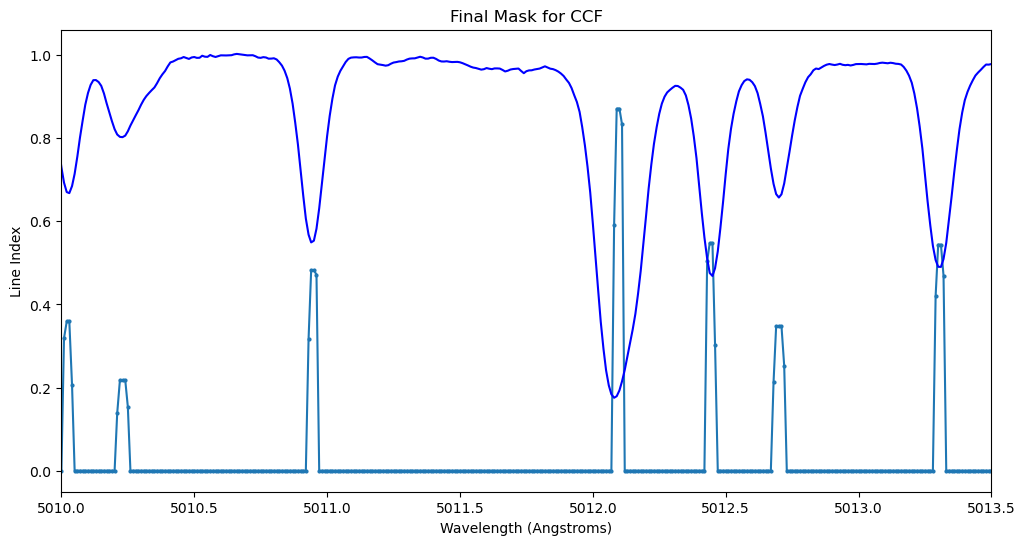

In [24]:
# Plot du masque final
plt.figure(figsize=(12, 6))
plt.plot(wavegrid_extended, final_mask, marker='o', linestyle='-', markersize=2)
extended_spec = np.zeros_like(wavegrid_extended)
extended_spec[np.isin(wavegrid_extended, wavegrid)] = specs[0, np.isin(wavegrid, wavegrid_extended)]
plt.plot(wavegrid_extended, extended_spec, label='Final Mask', color='blue')
plt.xlim(5010, 5013.5)
plt.xlabel('Wavelength (Angstroms)')
plt.ylabel('Line Index')
plt.title('Final Mask for CCF')
plt.show()

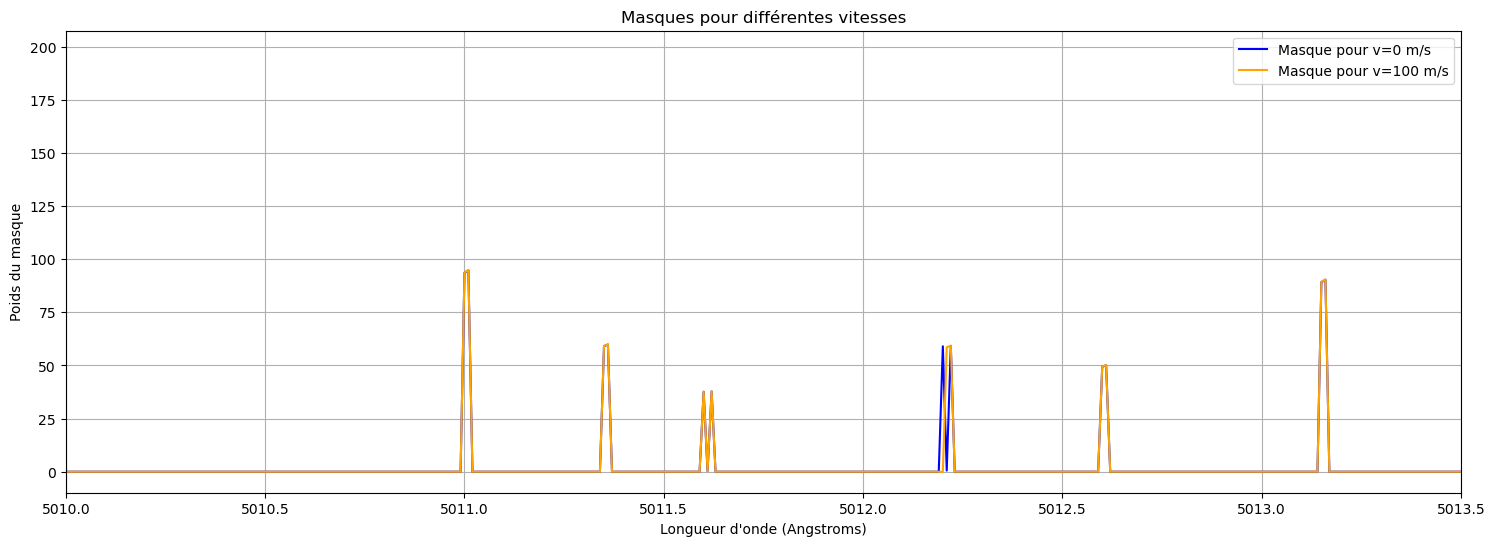

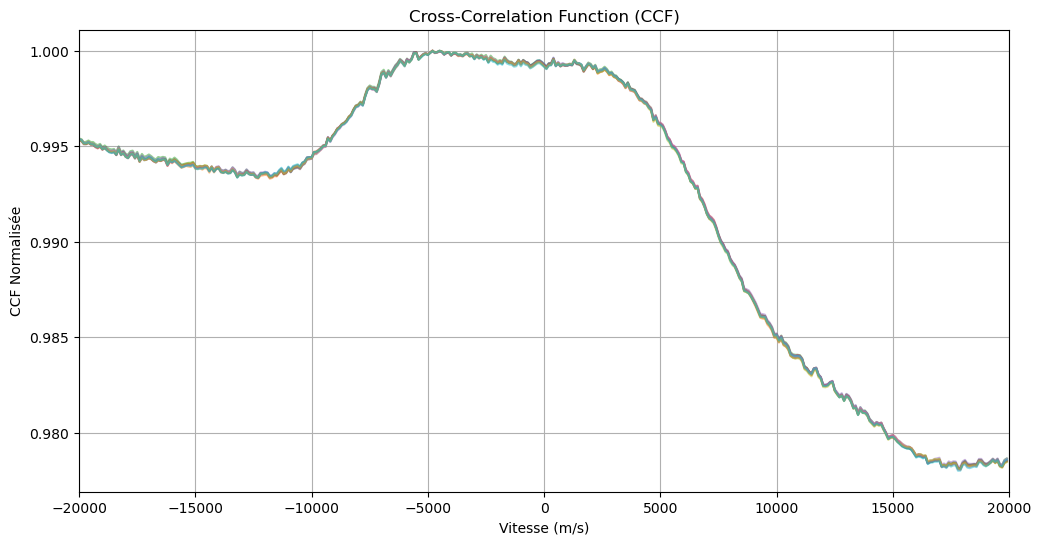

In [ ]:
# Optimisons les performances en évitant les opérations inutiles et en utilisant numba

@jit(nopython=True)
def calculate_all_masks(
    line_pos: np.ndarray, 
    line_weights: np.ndarray, 
    v_grid: np.ndarray, 
    wavegrid: np.ndarray, 
    window_size_velocity: float
    ):
    
    """
    Calcule le masque pour toutes les vitesses de la grille.
    Cette fonction calcule le masque pour chaque vitesse de la grille en utilisant les positions et poids des raies,
    et étend la grille de longueurs d'onde pour tenir compte des décalages Doppler.

    Args:
        line_pos (np.ndarray): Positions des raies spectrales.
        line_weights (np.ndarray): Poids associés à chaque raie spectrale.
        v_grid (np.ndarray): Grille de vitesses pour laquelle le masque est calculé.
        wavegrid (np.ndarray): Grille de longueurs d'onde sur laquelle les raies sont définies.
        window_size_velocity (float): Taille de la fenêtre en espace de vitesse.
    """
    c = 299792458.0
    wavegrid_step = wavegrid[1] - wavegrid[0]

    velocity_grid_max = v_grid.max() + 100  # Sécurité
    max_shift = np.sqrt((1 + velocity_grid_max/c) / (1 - velocity_grid_max/c)) * wavegrid.max()
    min_shift = np.sqrt((1 - velocity_grid_max/c) / (1 + velocity_grid_max/c)) * wavegrid.min()

    # Extension avant la grille
    wave_before = np.arange(min_shift, wavegrid.min(), wavegrid_step)
    # Extension après la grille  
    wave_after = np.arange(wavegrid.max() + wavegrid_step, max_shift, wavegrid_step)
    
    # Concaténation compatible avec Numba
    total_length = len(wave_before) + len(wavegrid) + len(wave_after)
    wavegrid_extended = np.empty(total_length)
    
    # Copier les trois parties
    wavegrid_extended[:len(wave_before)] = wave_before
    wavegrid_extended[len(wave_before):len(wave_before)+len(wavegrid)] = wavegrid
    wavegrid_extended[len(wave_before)+len(wavegrid):] = wave_after

    begin_wave = wavegrid_extended[0]

    masks = np.zeros((len(v_grid), len(wavegrid_extended)))
    
    for i, v_shift in enumerate(v_grid):
        gamma_shift = np.sqrt((1 + v_shift/c) / (1 - v_shift/c))
        gamma_window = np.sqrt((1 + window_size_velocity/c) / (1 - window_size_velocity/c))
        
        for j in range(len(line_pos)):
            line_shifted = line_pos[j] * gamma_shift
            window_size = line_pos[j] * gamma_window - line_pos[j]
            
            window_start = line_shifted - window_size / 2
            window_end = line_shifted + window_size / 2

            start_idx = int(np.ceil((window_start - begin_wave) / wavegrid_step))
            end_idx = int(np.ceil((window_end - begin_wave) / wavegrid_step) - 1)
            
            if start_idx < 1 or end_idx >= len(wavegrid_extended) - 1:
                continue
            
            if start_idx > end_idx:
                continue
            
            fraction_before = abs(wavegrid_extended[start_idx] - window_start) / wavegrid_step
            fraction_after = abs(wavegrid_extended[end_idx] - window_end) / wavegrid_step
            
            masks[i, start_idx - 1] += line_weights[j] * fraction_before
            masks[i, end_idx] += line_weights[j] * fraction_after

            for k in range(start_idx, end_idx):
                masks[i, k] += line_weights[j]
            

    # On crop le mask pour ne garder que la partie utile (wave)
    start_crop = len(wave_before)
    end_crop = len(wave_before) + len(wavegrid)
    masks = masks[:, start_crop:end_crop]
    

    return masks

# Exemple d'utilisation de la fonction pour calculer le masque pour une grille de vitesses
v_grid = np.arange(-20000, 20000, 100)  # Exemple de grille de vitesses
window_size_velocity = 820  # en m/s (paramètre)
masks = calculate_all_masks(line_pos, line_weights, v_grid, wavegrid, window_size_velocity)

plt.figure(figsize=(18, 6))
plt.plot(wavegrid, masks[200], label='Masque pour v=0 m/s', color='blue')
plt.plot(wavegrid, masks[201], label='Masque pour v=100 m/s', color='orange')
plt.xlabel('Longueur d\'onde (Angstroms)')
plt.ylabel('Poids du masque')
plt.title('Masques pour différentes vitesses')  
plt.legend()
plt.xlim(5010, 5013.5)
plt.grid()
plt.show()

def calculate_CCF(masks, spec):
    """
    Calcule la CCF à partir des masques et de la grille de longueurs d'onde.
    
    Args:
        masks (np.ndarray): Masques calculés pour chaque vitesse.
        spec (np.ndarray): Spectre à convoluer avec les masques.
    
    Returns:
        np.ndarray: CCF calculée.
    """
    ccf = np.sum(masks * spec, axis=1)
    ccf = ccf / np.max(ccf)  # Normalisation de la CCF
    
    return ccf

ccfs = []
for spec in specs:
    ccf = calculate_CCF(masks, spec)
    ccfs.append(ccf)
ccfs = np.array(ccfs)

plt.figure(figsize=(12, 6))
plt.plot(v_grid, ccfs.T, alpha=0.5)
plt.xlabel("Vitesse (m/s)")
plt.ylabel("CCF Normalisée")
plt.title("Cross-Correlation Function (CCF)")
plt.xlim(-20000, 20000)
plt.grid()
plt.show()

In [17]:
np.where(v_grid == 0)

(array([200]),)

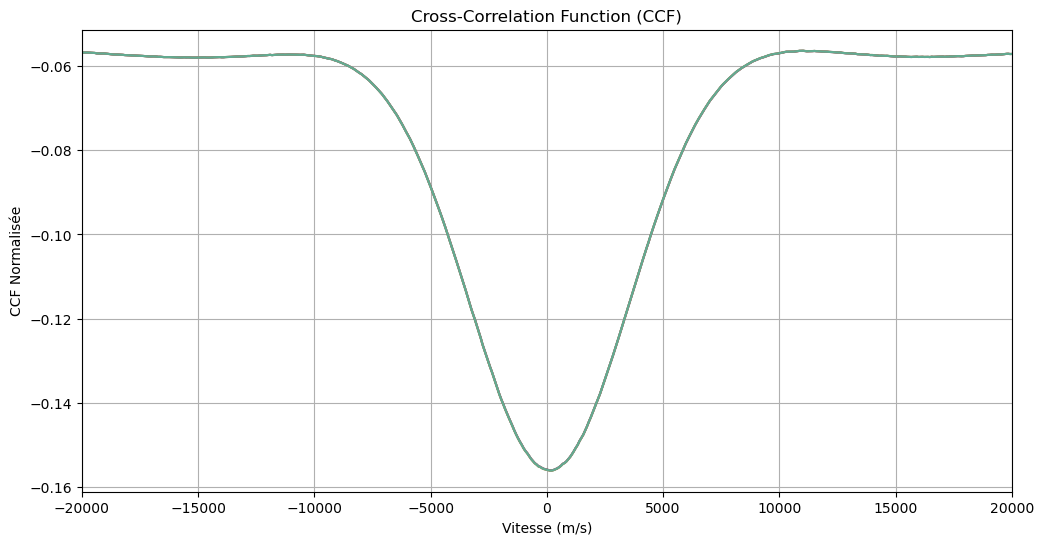

In [35]:
import numpy as np
from numba import jit


@jit(nopython=True)
def calculate_gaussian_masks(
    line_pos: np.ndarray,
    line_weights: np.ndarray,
    v_grid: np.ndarray,
    wavegrid: np.ndarray,
    fwhm_velocity: float,
):
    """
    Construit un masque gaussien pour chaque vitesse de v_grid,
    en considérant chaque raie centrée sur lambda_shiftée avec largeur FWHM.

    Args:
        line_pos: positions des raies (lambda_0)
        line_weights: poids relatifs des raies
        v_grid: grille de vitesses RV (m/s)
        wavegrid: grille de longueurs d'onde (même unité que line_pos)
        fwhm_velocity: largeur à mi-hauteur en m/s (même pour toutes les raies)

    Returns:
        masks: tableau (len(v_grid), len(wavegrid)) de masques normalisés
    """
    c = 299_792_458.0
    nl = len(line_pos)
    nm = len(v_grid)
    nw = len(wavegrid)
    masks = np.zeros((nm, nw))

    # conversion FWHM -> sigma en lambda
    sigma_frac = (fwhm_velocity / c) / (2.0 * np.sqrt(2.0 * np.log(2.0)))

    for i in range(nm):
        v = v_grid[i]
        shift_factor = 1.0 + v / c  # approximation non-relativiste
        total_weight = 0.0

        # pour chaque raie, ajouter un profil gaussien
        for j in range(nl):
            lam0 = line_pos[j]
            w = line_weights[j]

            lam_c = lam0 * shift_factor
            sigma = lam0 * sigma_frac

            # calculer plage utile ±4σ
            start = lam_c - 4.0 * sigma
            end = lam_c + 4.0 * sigma

            # indices
            idx0 = int(np.searchsorted(wavegrid, start))
            idx1 = int(np.searchsorted(wavegrid, end))
            if idx0 < 0:
                idx0 = 0
            if idx1 >= nw:
                idx1 = nw - 1

            # profil gaussien
            for k in range(idx0, idx1 + 1):
                x = wavegrid[k] - lam_c
                masks[i, k] += w * np.exp(-0.5 * (x / sigma) ** 2)
                total_weight += w

        # normalisation pour que somme des poids = 1
        if total_weight > 0:
            masks[i, :] /= total_weight

    return masks


def calculate_CCF_gaussian(masks: np.ndarray, spec: np.ndarray) -> np.ndarray:
    """
    Calcule la CCF gaussienne en convoluant avec (spec_norm - 1).
    La CCF sera négative aux vitesses où l'absorption est maximale.
    """
    spec0 = spec - 1.0
    ccf = masks.dot(spec0)
    return ccf


# Exemple d’utilisation
v_grid = np.linspace(-20e3, 20e3, 500)  # -20→+20 km/s
fwhm_vel = 4_000.0  # FWHM de 4 km/s
masks = calculate_gaussian_masks(line_pos, line_weights, v_grid, wavegrid, fwhm_vel)

ccfs = np.array([calculate_CCF_gaussian(masks, sp) for sp in specs])

plt.figure(figsize=(12, 6))
plt.plot(v_grid, ccfs.T, alpha=0.5)
plt.xlabel("Vitesse (m/s)")
plt.ylabel("CCF Normalisée")
plt.title("Cross-Correlation Function (CCF)")
plt.xlim(-20000, 20000)
plt.grid()
plt.show()

In [18]:
import numpy as np
import numba
from scipy.optimize import least_squares
import matplotlib.pyplot as plt

# Configuration Numba pour optimisation maximale
@numba.jit(nopython=True, cache=True, parallel=False)
def gaussian_function(x, c, k, x0, fwhm):
    """
    Fonction gaussienne pour fit CCF
    
    Parameters:
    -----------
    x : array-like
        Grille de vitesses radiales (m/s)
    c : float
        Continuum (baseline)
    k : float  
        Amplitude (profondeur du pic)
    x0 : float
        Position du centre (vitesse radiale en m/s)
    fwhm : float
        Largeur à mi-hauteur (en m/s)
    """
    sigma = fwhm / (2.0 * np.sqrt(2.0 * np.log(2.0)))
    return c + k * np.exp(-((x - x0)**2) / (2.0 * sigma**2))

@numba.jit(nopython=True, cache=True)
def gaussian_residuals(params, x, y, weights):
    """
    Calcul des résidus pour l'optimisation
    """
    c, k, x0, fwhm = params
    model = gaussian_function(x, c, k, x0, fwhm)
    return (model - y) * weights

@numba.jit(nopython=True, cache=True)
def estimate_initial_parameters(x, y):
    """
    Estimation des paramètres initiaux avec détection automatique de l'orientation
    """
    n = len(y)
    
    # Continuum : moyenne des bords
    c = (y[0] + y[-1]) / 2.0
    
    # FWHM initial : 1/5 de la plage
    fwhm = (x[-1] - x[0]) / 5.0
    
    # Position initiale : milieu
    x0 = x[n // 2]
    
    # Détection automatique de l'orientation et amplitude
    k = 0.0
    y_min = y[0]
    y_max = y[0]
    x_at_min = x[0]
    x_at_max = x[0]
    
    for i in range(n):
        if y[i] < y_min:
            y_min = y[i]
            x_at_min = x[i]
        if y[i] > y_max:
            y_max = y[i]
            x_at_max = x[i]
    
    # Choix de l'amplitude selon l'écart maximum par rapport au continuum
    if abs(y_min - c) > abs(y_max - c):
        # Gaussienne "à l'envers" (pic vers le bas)
        k = y_min - c  # k négatif
        x0 = x_at_min
    else:
        # Gaussienne "à l'endroit" (pic vers le haut)
        k = y_max - c  # k positif
        x0 = x_at_max
    
    return np.array([c, k, x0, fwhm])

@numba.jit(nopython=True, cache=True, parallel=True)
def calculate_bisector_points(x, y_fit, c, k, x0, fwhm, n_depth_points=91):
    """
    Calcul des points de bisecteur comme dans BIS_FIT2.cpp
    
    Cette fonction reproduit exactement la logique C++ pour le calcul
    des points de bisecteur en utilisant les dérivées analytiques.
    """
    # Paramètres comme dans le code C++
    nstep = 100
    margin = 5
    len_depth = nstep - 2 * margin + 1
    
    sigma = fwhm / (2.0 * np.sqrt(2.0 * np.log(2.0)))
    v0 = x0 + x[0]  # Comme dans le code C++
    
    # Allocations
    norm_CCF = np.zeros(len(x))
    depth = np.zeros(len_depth)
    bis = np.zeros(len_depth)
    p0 = np.zeros(len(x))
    p1 = np.zeros(len(x))
    p2 = np.zeros(len(x))
    
    # Normalisation de la CCF
    for i in range(len(x)):
        norm_CCF[i] = -k / c * (1.0 - y_fit[i] / c)
    
    # Calcul des profondeurs
    for i in range(len_depth):
        depth[i] = float(i + margin) / nstep
    
    # Calcul des coefficients polynomiaux pour chaque point
    for i in range(len(x) - 1):
        vr = (x[i] + x[i + 1]) / 2.0
        
        # Dérivées analytiques de la gaussienne
        exp_term = np.exp(-((vr - v0)**2) / (2.0 * sigma**2))
        dCCFdRV = -(vr - v0) / (sigma**2) * exp_term
        d2CCFdRV2 = (((vr - v0)**2) / (sigma**2) - 1) / (sigma**2) * exp_term
        d2RVdCCF2 = -d2CCFdRV2 / (dCCFdRV**3)
        
        # Coefficients polynomiaux
        p2[i] = d2RVdCCF2 / 2.0
        p1[i] = (x[i + 1] - x[i] - p2[i] * (norm_CCF[i + 1]**2 - norm_CCF[i]**2)) / (norm_CCF[i + 1] - norm_CCF[i])
        p0[i] = x[i] - p1[i] * norm_CCF[i] - p2[i] * norm_CCF[i]**2
    
    # Recherche du maximum
    ind_max = 0
    for i in range(len(x)):
        if norm_CCF[i] > norm_CCF[ind_max]:
            ind_max = i
    
    # Calcul du bisecteur
    for i in range(len_depth):
        i_b = ind_max
        i_r = ind_max
        
        # Recherche côté bleu
        while (norm_CCF[i_b] > depth[i]) and (i_b > 1):
            i_b -= 1
        
        # Recherche côté rouge  
        while (norm_CCF[i_r + 1] > depth[i]) and (i_r < len(x) - 2):
            i_r += 1
        
        # Interpolation polynomiale
        bis_left = p0[i_b] + p1[i_b] * depth[i] + p2[i_b] * depth[i]**2
        bis_right = p0[i_r] + p1[i_r] * depth[i] + p2[i_r] * depth[i]**2
        bis[i] = (bis_left + bis_right) / 2.0
    
    return depth, bis

@numba.jit(nopython=True, cache=True, parallel=False)
def linear_gaussian(x, c, k, x0, fwhm, slope):
    """
    Fonction gaussienne avec continuum linéaire (incliné).
    
    Parameters:
    -----------
    x : np.ndarray
        Grille de vitesses radiales (m/s).
    c : float
        Continuum au centre (baseline).
    k : float
        Amplitude (profondeur du pic).
    x0 : float
        Position du centre (vitesse radiale en m/s).
    fwhm : float
        Largeur à mi-hauteur (en m/s).
    slope : float
        Pente du continuum (en unités CCF / (m/s)).
    
    Returns:
    --------
    np.ndarray
        Valeurs de la fonction gaussienne avec continuum incliné.
    """
    sigma = fwhm / (2.0 * np.sqrt(2.0 * np.log(2.0)))
    continuum = c + slope * (x - x0)  # Continuum linéaire centré sur x0
    gaussian = k * np.exp(-((x - x0)**2) / (2.0 * sigma**2))
    return continuum + gaussian

@numba.jit(nopython=True, cache=True)
def residuals_lin_gauss(params, x, y, weights):
    """
    Calcul des résidus pour l'optimisation gaussienne avec continuum linéaire.
    """
    c, k, x0, fwhm, slope = params
    model = linear_gaussian(x, c, k, x0, fwhm, slope)
    return (model - y) * weights

@numba.jit(nopython=True, cache=True)
def estimate_initial_parameters_linear(x, y):
    """
    Estimation des paramètres initiaux pour fit avec continuum linéaire.
    
    Parameters:
    -----------
    x : np.ndarray
        Grille de vitesses.
    y : np.ndarray
        Valeurs de la CCF.
    
    Returns:
    --------
    np.ndarray
        Paramètres initiaux [c, k, x0, fwhm, slope].
    """
    n = len(y)
    
    # Estimation de la pente du continuum avec les bords
    slope = (y[-1] - y[0]) / (x[-1] - x[0])
    
    # Continuum au centre après soustraction de la pente
    x_center = (x[0] + x[-1]) / 2.0
    continuum_center = y[0] + slope * (x_center - x[0])
    
    # FWHM initial : 1/5 de la plage
    fwhm_init = (x[-1] - x[0]) / 5.0
    
    # Position du pic/creux
    idx_extremum = 0
    val_extremum = y[0]
    for i in range(1, n):
        if abs(y[i] - continuum_center) > abs(val_extremum - continuum_center):
            val_extremum = y[i]
            idx_extremum = i
    
    x0_init = x[idx_extremum]
    
    # Amplitude : différence entre l'extremum et le continuum au même point
    continuum_at_extremum = continuum_center + slope * (x0_init - x_center)
    k_init = val_extremum - continuum_at_extremum
    
    return np.array([continuum_center, k_init, x0_init, fwhm_init, slope])

class CCFGaussianFitter:
    """
    Classe avancée pour le fit gaussien des CCF avec support pour:
    - Continuum plat (comme CCFGaussianFitter original)
    - Continuum linéaire (incliné)
    - Calcul de bisecteur adaptatif
    """
    
    def __init__(self):
        """Initialisation du fitter avancé."""
        self.fitted_params = None
        self.covariance = None
        self.bisector_depth = None
        self.bisector_velocity = None
        self.fit_quality = None
        self.continuum_type = 'flat'  # 'flat' ou 'linear'
    
    def fit_ccf(self, velocity, ccf, weights=None, continuum='auto', verbose=False):
        """
        Fit gaussien de la CCF avec choix du type de continuum.
        
        Parameters:
        -----------
        velocity : array-like
            Grille de vitesses radiales (m/s)
        ccf : array-like  
            Valeurs de la CCF (normalisées)
        weights : array-like, optional
            Poids pour le fit (défaut: poids uniformes)
        continuum : str
            Type de continuum: 'flat', 'linear', ou 'auto'
        verbose : bool
            Affichage des résultats
            
        Returns:
        --------
        dict : Résultats du fit avec paramètres et bisecteur
        """
        
        # Conversion en arrays numpy
        x = np.asarray(velocity, dtype=np.float64)
        y = np.asarray(ccf, dtype=np.float64)
        
        if weights is None:
            weights = np.ones_like(y)
        else:
            weights = np.asarray(weights, dtype=np.float64)
        
        # Choix automatique du type de continuum
        if continuum == 'auto':
            # Teste la pente du continuum
            slope_estimate = (y[-1] - y[0]) / (x[-1] - x[0])
            if abs(slope_estimate) > 1e-6:  # Seuil ajustable
                continuum = 'linear'
            else:
                continuum = 'flat'
            if verbose:
                print(f"Continuum auto-détecté: {continuum} (pente estimée: {slope_estimate:.2e})")
        
        self.continuum_type = continuum
        
        if continuum == 'linear':
            return self._fit_linear_continuum(x, y, weights, verbose)
        else:
            return self._fit_flat_continuum(x, y, weights, verbose)
    
    def _fit_flat_continuum(self, x, y, weights, verbose):
        """Fit avec continuum plat (méthode originale)."""
        # Estimation des paramètres initiaux
        p0 = estimate_initial_parameters(x, y)
        
        # Définition de la fonction de résidus pour scipy
        def residuals_wrapper(params):
            return gaussian_residuals(params, x, y, weights)
        
        # Optimisation avec scipy.optimize.least_squares
        result = least_squares(
            residuals_wrapper, 
            p0,
            method='lm',
            max_nfev=10000
        )
        
        if not result.success and verbose:
            print(f"Warning: Fit did not converge. Status: {result.message}")
        
        # Extraction des paramètres
        c, k, x0, fwhm = result.x
        self.fitted_params = result.x
        
        # Calcul de la covariance
        try:
            J = result.jac
            cov = np.linalg.inv(J.T @ J) * (result.fun @ result.fun) / (len(x) - len(p0))
            self.covariance = cov
            param_errors = np.sqrt(np.diag(cov))
        except:
            param_errors = np.zeros(4)
            self.covariance = np.eye(4)
        
        # Modèle ajusté
        y_fit = gaussian_function(x, c, k, x0, fwhm)
        
        # Calcul du bisecteur avec Numba
        depth, bis = calculate_bisector_points(x, y_fit, c, k, x0, fwhm)
        self.bisector_depth = depth
        self.bisector_velocity = bis
        
        # Calcul du span
        if k > 0:
            depth_for_span = 1.0 - depth
        else:
            depth_for_span = depth
        
        mask_top = (depth_for_span >= 0.1) & (depth_for_span <= 0.4)
        mask_bottom = (depth_for_span >= 0.6) & (depth_for_span <= 0.9)
        
        if np.any(mask_top) and np.any(mask_bottom):
            RV_top = np.mean(bis[mask_top])
            RV_bottom = np.mean(bis[mask_bottom])
            span = abs(RV_top - RV_bottom)
        else:
            span = np.nan
        
        # Qualité du fit
        chi2 = np.sum(((y_fit - y) * weights)**2)
        reduced_chi2 = chi2 / (len(x) - len(p0))
        self.fit_quality = {
            'chi2': chi2,
            'reduced_chi2': reduced_chi2,
            'success': result.success
        }
        
        # Résultats
        results = {
            'continuum': c,
            'amplitude': k,
            'rv_center': x0,
            'fwhm': fwhm,
            'span': span,
            'slope': 0.0,  # Pas de pente pour continuum plat
            'continuum_err': param_errors[0],
            'amplitude_err': param_errors[1],
            'rv_center_err': param_errors[2],
            'fwhm_err': param_errors[3],
            'slope_err': 0.0,
            'velocity': x,
            'ccf_observed': y,
            'ccf_fitted': y_fit,
            'bisector_depth': depth,
            'bisector_velocity': bis,
            'fit_quality': self.fit_quality,
            'continuum_type': 'flat'
        }
        
        if verbose:
            print(f"Fit Results (continuum plat):")
            print(f"  Continuum: {c:.6f} ± {param_errors[0]:.6f}")
            print(f"  Amplitude: {k:.6f} ± {param_errors[1]:.6f}")
            print(f"  RV Center: {x0:.1f} ± {param_errors[2]:.1f} m/s")
            print(f"  FWHM: {fwhm:.1f} ± {param_errors[3]:.1f} m/s")
            print(f"  Span: {span:.1f} m/s")
            print(f"  Reduced χ²: {reduced_chi2:.3f}")
        
        return results
    
    def _fit_linear_continuum(self, x, y, weights, verbose):
        """Fit avec continuum linéaire (incliné)."""
        # Estimation des paramètres initiaux
        p0 = estimate_initial_parameters_linear(x, y)
        
        # Définition de la fonction de résidus pour scipy
        def residuals_wrapper(params):
            return residuals_lin_gauss(params, x, y, weights)
        
        # Optimisation avec scipy.optimize.least_squares
        result = least_squares(
            residuals_wrapper, 
            p0,
            method='lm',
            max_nfev=10000
        )
        
        if not result.success and verbose:
            print(f"Warning: Fit did not converge. Status: {result.message}")
        
        # Extraction des paramètres
        c, k, x0, fwhm, slope = result.x
        self.fitted_params = result.x
        
        # Calcul de la covariance
        try:
            J = result.jac
            cov = np.linalg.inv(J.T @ J) * (result.fun @ result.fun) / (len(x) - len(p0))
            self.covariance = cov
            param_errors = np.sqrt(np.diag(cov))
        except:
            param_errors = np.zeros(5)
            self.covariance = np.eye(5)
        
        # Modèle ajusté
        y_fit = linear_gaussian(x, c, k, x0, fwhm, slope)
        
        # Pour le bisecteur, on utilise une approximation avec continuum équivalent
        # au centre pour réutiliser la fonction existante
        depth, bis = calculate_bisector_points(x, y_fit, c, k, x0, fwhm)
        self.bisector_depth = depth
        self.bisector_velocity = bis
        
        # Calcul du span (même logique que pour continuum plat)
        if k > 0:
            depth_for_span = 1.0 - depth
        else:
            depth_for_span = depth
        
        mask_top = (depth_for_span >= 0.1) & (depth_for_span <= 0.4)
        mask_bottom = (depth_for_span >= 0.6) & (depth_for_span <= 0.9)
        
        if np.any(mask_top) and np.any(mask_bottom):
            RV_top = np.mean(bis[mask_top])
            RV_bottom = np.mean(bis[mask_bottom])
            span = abs(RV_top - RV_bottom)
        else:
            span = np.nan
        
        # Qualité du fit
        chi2 = np.sum(((y_fit - y) * weights)**2)
        reduced_chi2 = chi2 / (len(x) - len(p0))
        self.fit_quality = {
            'chi2': chi2,
            'reduced_chi2': reduced_chi2,
            'success': result.success
        }
        
        # Résultats
        results = {
            'continuum': c,
            'amplitude': k,
            'rv_center': x0,
            'fwhm': fwhm,
            'span': span,
            'slope': slope,
            'continuum_err': param_errors[0],
            'amplitude_err': param_errors[1],
            'rv_center_err': param_errors[2],
            'fwhm_err': param_errors[3],
            'slope_err': param_errors[4],
            'velocity': x,
            'ccf_observed': y,
            'ccf_fitted': y_fit,
            'bisector_depth': depth,
            'bisector_velocity': bis,
            'fit_quality': self.fit_quality,
            'continuum_type': 'linear'
        }
        
        if verbose:
            print(f"Fit Results (continuum linéaire):")
            print(f"  Continuum: {c:.6f} ± {param_errors[0]:.6f}")
            print(f"  Amplitude: {k:.6f} ± {param_errors[1]:.6f}")
            print(f"  RV Center: {x0:.1f} ± {param_errors[2]:.1f} m/s")
            print(f"  FWHM: {fwhm:.1f} ± {param_errors[3]:.1f} m/s")
            print(f"  Pente: {slope:.2e} ± {param_errors[4]:.2e} /m/s")
            print(f"  Span: {span:.1f} m/s")
            print(f"  Reduced χ²: {reduced_chi2:.3f}")
        
        return results
    
    def plot_results(self, results, figsize=(14, 10)):
        """
        Visualisation avancée des résultats du fit.
        
        Parameters:
        -----------
        results : Dict
            Résultats du fit retournés par fit_ccf().
        figsize : Tuple[int, int]
            Taille de la figure.
        
        Returns:
        --------
        plt.Figure
            Figure matplotlib avec les résultats.
        """
        fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=figsize)
        
        # CCF et fit
        ax1.plot(results['velocity'], results['ccf_observed'], 'b-', 
                label='CCF observée', alpha=0.7, linewidth=1)
        ax1.plot(results['velocity'], results['ccf_fitted'], 'r-', 
                label=f'Fit gaussien ({results["continuum_type"]})', linewidth=2)
        
        # Affichage du continuum si linéaire
        if results['continuum_type'] == 'linear' and results['slope'] != 0:
            x = results['velocity']
            x0 = results['rv_center']
            continuum_line = results['continuum'] + results['slope'] * (x - x0)
            ax1.plot(x, continuum_line, 'g--', alpha=0.7, 
                    label=f'Continuum (pente={results["slope"]:.2e})')
        
        ax1.set_xlabel('Vitesse radiale (m/s)')
        ax1.set_ylabel('CCF')
        ax1.set_title(f'Fit gaussien de la CCF - Continuum {results["continuum_type"]}')
        ax1.legend()
        ax1.grid(True, alpha=0.3)
        
        # Résidus
        residuals = results['ccf_observed'] - results['ccf_fitted']
        ax2.plot(results['velocity'], residuals, 'g-', alpha=0.7)
        ax2.axhline(0, color='k', linestyle='--', alpha=0.5)
        ax2.set_xlabel('Vitesse radiale (m/s)')
        ax2.set_ylabel('Résidus')
        ax2.set_title('Résidus du fit')
        ax2.grid(True, alpha=0.3)
        
        # Bisecteur
        if results['bisector_depth'] is not None and results['bisector_velocity'] is not None:
            ax3.plot(results['bisector_velocity'], results['bisector_depth'], 'o-', 
                    markersize=4, linewidth=2, color='purple')
            ax3.set_xlabel('Vitesse radiale (m/s)')
            ax3.set_ylabel('Profondeur relative')
            ax3.set_title(f'Bisecteur (Span = {results["span"]:.1f} m/s)')
            ax3.grid(True, alpha=0.3)
            ax3.invert_yaxis()
        
        # Informations du fit
        ax4.axis('off')
        info_text = f"""Paramètres du fit ({results['continuum_type']}):
        
Continuum: {results['continuum']:.6f} ± {results['continuum_err']:.6f}
Amplitude: {results['amplitude']:.6f} ± {results['amplitude_err']:.6f}
RV Centre: {results['rv_center']:.1f} ± {results['rv_center_err']:.1f} m/s
FWHM: {results['fwhm']:.1f} ± {results['fwhm_err']:.1f} m/s"""
        
        if results['continuum_type'] == 'linear':
            info_text += f"\nPente: {results['slope']:.2e} ± {results['slope_err']:.2e} /m/s"
        
        info_text += f"""
        
Span: {results['span']:.1f} m/s
χ² réduit: {results['fit_quality']['reduced_chi2']:.3f}
Succès: {results['fit_quality']['success']}"""
        
        ax4.text(0.1, 0.9, info_text, transform=ax4.transAxes, 
                fontsize=10, verticalalignment='top', fontfamily='monospace')
        
        plt.tight_layout()
        return fig

Fit pour le spectre de référence (quiet):
  RV Centre: -142.66232546698748 m/s


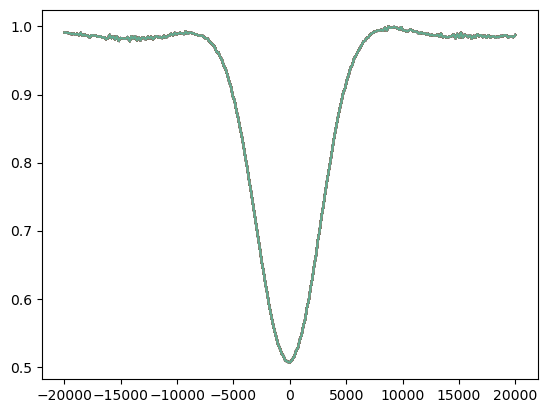

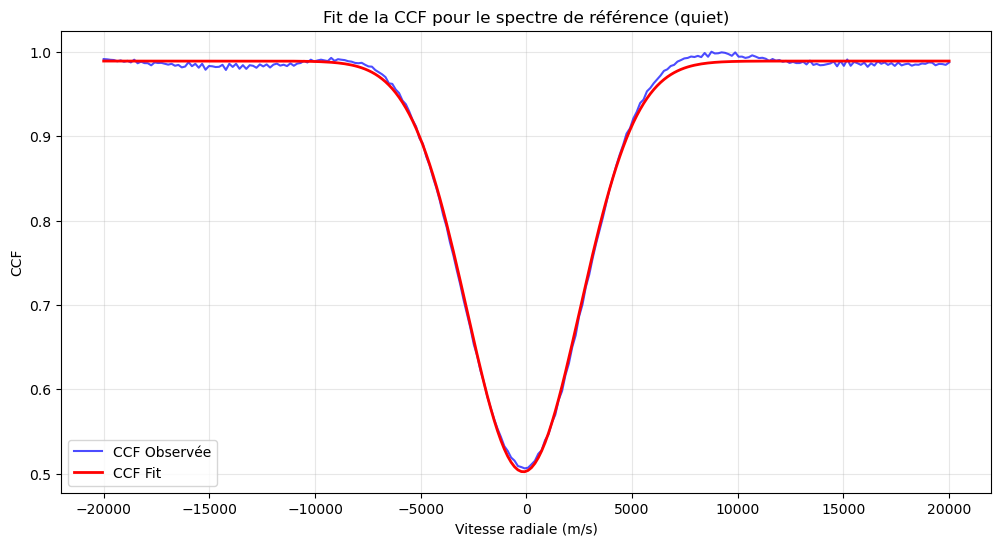

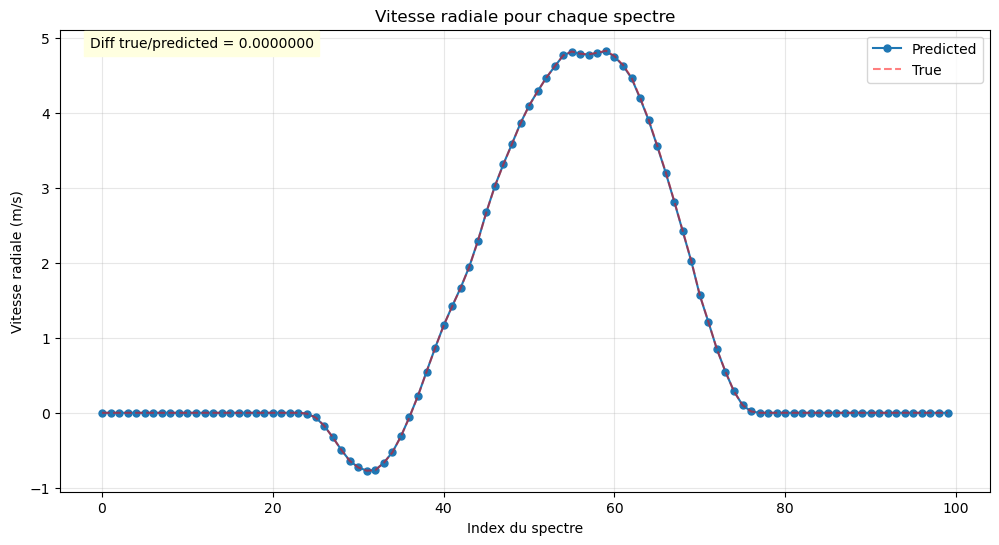

In [8]:
fitter = CCFGaussianFitter()

rvs = []
rvs_errors = []
for ccf in ccfs:
    results = fitter.fit_ccf(v_grid, ccf, continuum='flat')
    rv = results['rv_center']
    rv_error = results['rv_center_err']
    plt.plot(v_grid, ccf, label=f'CCF {len(rvs)+1}', alpha=0.5)
    rvs.append(rv)
    rvs_errors.append(rv_error)

rvs = np.array(rvs)
rvs_errors = np.array(rvs_errors)

spec_quiet = np.fromfile('./data/soap_simple_faculae/test_simple_SED_quiet_sun_lower_spec.bin', dtype=np.float64)
ccf_quiet = calculate_CCF(masks, spec=spec_quiet)

# Fit pour le spectre de référence
results_quiet = fitter.fit_ccf(v_grid, ccf_quiet, continuum='flat')
# Affichage des résultats du fit pour le spectre de référence
print("Fit pour le spectre de référence (quiet):")
print(f"  RV Centre: {results_quiet['rv_center']} m/s")

# Plot du fit
plt.figure(figsize=(12, 6))
plt.plot(v_grid, ccf_quiet, 'b-', label='CCF Observée', alpha=0.7)
plt.plot(v_grid, results_quiet['ccf_fitted'], 'r-', label='CCF Fit', linewidth=2)
plt.xlabel('Vitesse radiale (m/s)')
plt.ylabel('CCF')
plt.title('Fit de la CCF pour le spectre de référence (quiet)')
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()

# Centrer toutes les vitesses radiales autour de la vitesse de référence
rvs -= results_quiet['rv_center']
true_rvs = np.load('data/soap_simple_faculae/test_simple_GPU_SOAP_RV_data.npz')['tot']

# Plot
plt.figure(figsize=(12, 6))
plt.plot(np.arange(len(rvs)), rvs, 'o-', label='Predicted', markersize=5)
plt.plot(np.arange(len(rvs)), true_rvs, 'r--', label='True', alpha=0.5)
plt.figtext(0.15, 0.85, f"Diff true/predicted = {np.median(rvs - true_rvs):.7f}", fontsize=10, backgroundcolor='lightyellow')
plt.xlabel('Index du spectre')
plt.ylabel('Vitesse radiale (m/s)')
plt.title('Vitesse radiale pour chaque spectre')
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()

# Comparaison méthodes des masques avec méthodes template + interpolation
Etudions comment la méthode des masques influence la précision vs la méthode template + interpolation qui fait perdre beaucoup de temps de calcul mais en théorie a une précision optimale.

### Méthode des masques:
- On shift les raies d'un masque donnée sur une grille de vitesses radiales puis on construit les fenêtre autour de chaque raie de manière fractionnaire en considérant le % de recouvrement du pixel dans la grille finale, puis on calcule la CCF avec np.sum(masks * spec)
### Méthode template + interpolation:
- On shift + interpole un template sur une grille de vitesses radiales puis on fait np.sum(shifted_templates * spec)

Using device: cuda
Processing 100 velocities in batches of 10
Processing batch 1/10 (velocities 0 to 9)
Processing batch 2/10 (velocities 10 to 19)
Processing batch 3/10 (velocities 20 to 29)
Processing batch 4/10 (velocities 30 to 39)
Processing batch 5/10 (velocities 40 to 49)
Processing batch 6/10 (velocities 50 to 59)
Processing batch 7/10 (velocities 60 to 69)
Processing batch 8/10 (velocities 70 to 79)
Processing batch 9/10 (velocities 80 to 89)
Processing batch 10/10 (velocities 90 to 99)


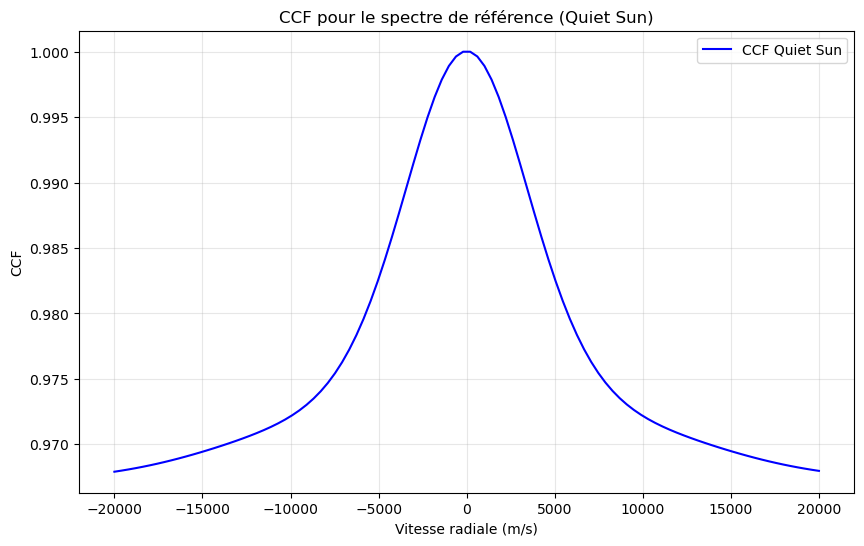

Fit Results (continuum linéaire):
  Continuum: 0.969465 ± 0.000125
  Amplitude: 0.029650 ± 0.000261
  RV Center: -0.0 ± 41.0 m/s
  FWHM: 9634.1 ± 108.7 m/s
  Pente: 1.62e-09 ± 7.64e-09 /m/s
  Span: 12258561026017.6 m/s
  Reduced χ²: 0.000
Fit pour le spectre de référence (quiet):
  RV Centre: -0.044 m/s


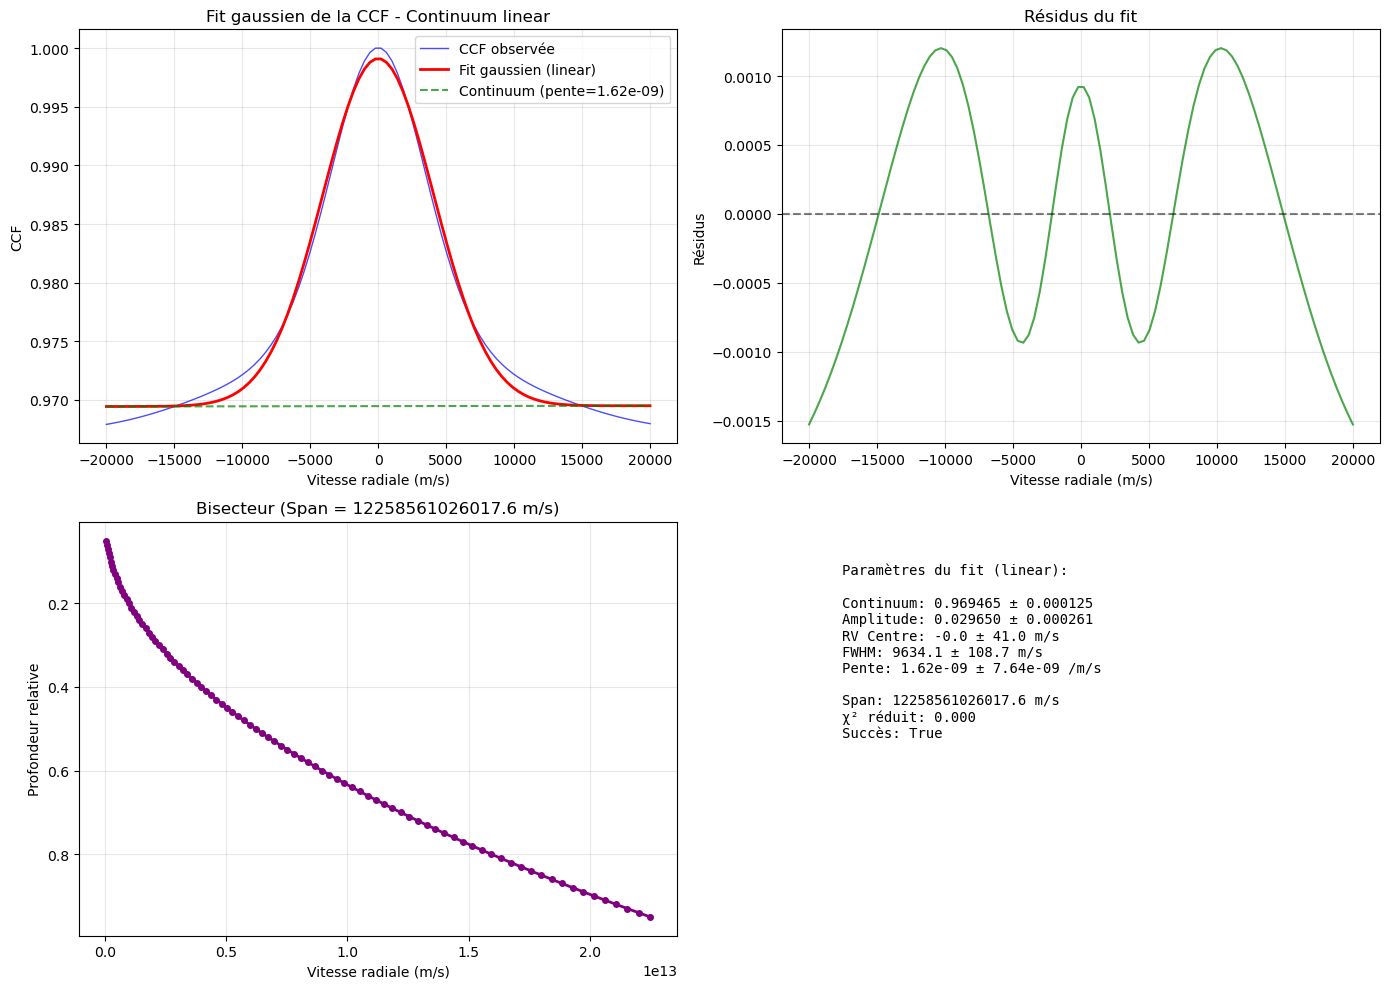

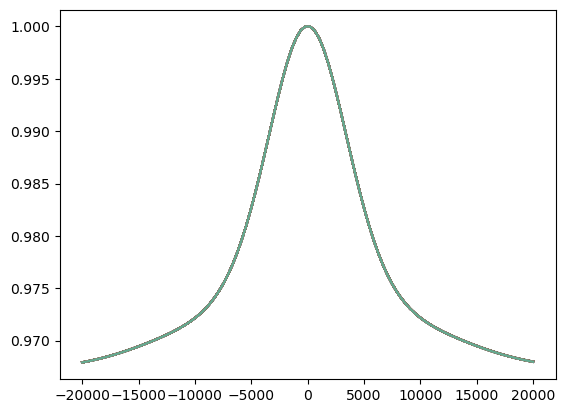

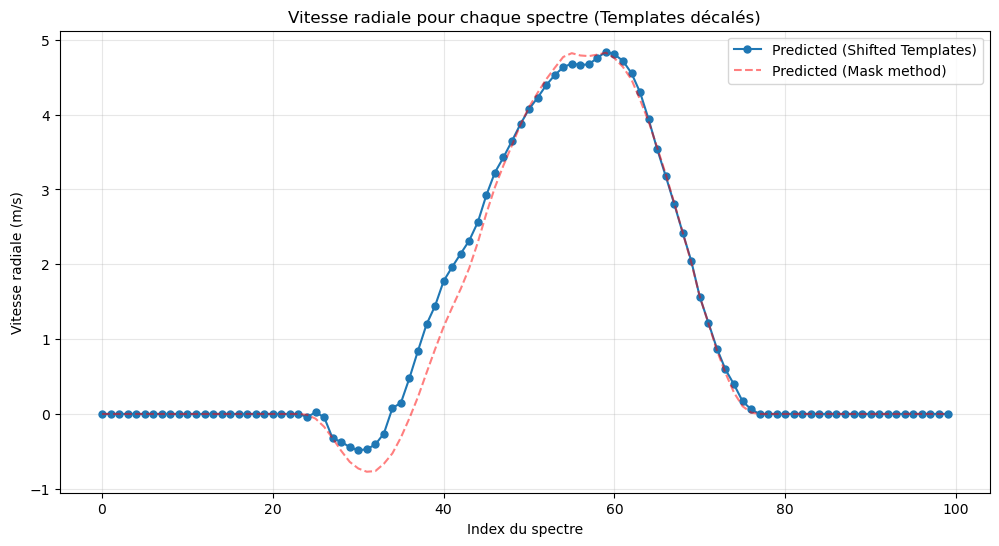

In [9]:
import torch
import numpy as np

def linear_interpolate(x_ref: torch.Tensor, y_ref: torch.Tensor, x_new: torch.Tensor) -> torch.Tensor:
    """
    Fast linear interpolation with linear extrapolation at boundaries.

    Args:
        x_ref: Reference points (increasing), shape (..., W)
        y_ref: Reference values, same shape as x_ref
        x_new: New points to interpolate at, same shape as x_ref

    Returns:
        Interpolated values at x_new
    """
    # Compute slopes and offsets
    m = torch.diff(y_ref, dim=-1) / torch.diff(x_ref, dim=-1)
    b = y_ref[..., :-1] - m * x_ref[..., :-1]
    
    # Find segment indices
    idx = torch.searchsorted(x_ref, x_new, right=False)

    # Extend slopes and offsets for extrapolation
    m_pad = torch.cat([
        m[..., :1],        # First segment slope
        m,
        m[..., -1:]        # Last segment slope
    ], dim=-1)
    b_pad = torch.cat([
        b[..., :1],        # First segment offset
        b,
        b[..., -1:]        # Last segment offset
    ], dim=-1)
    
    # Clamp indices for boundary handling
    idx = idx.clamp(0, m_pad.shape[-1]-1)

    # Select coefficients and interpolate
    m_sel = m_pad.gather(-1, idx)
    b_sel = b_pad.gather(-1, idx)
    return m_sel * x_new + b_sel


def calculate_all_shifted_templates_batched(template, v_grid, wavegrid, batch_size=50):
    """
    Calculate all shifted templates for the given velocity grid using batch processing.
    This version processes velocities in batches to avoid GPU memory issues.

    Args:
        template: Template spectrum to shift.
        v_grid: Velocity grid for shifting.
        wavegrid: Wavelength grid.
        batch_size: Number of velocities to process simultaneously.

    Returns:
        Shifted templates as a numpy array.
    """
    c = 299792458.0  # Speed of light in m/s
    
    # Check if CUDA is available
    device = 'cuda' if torch.cuda.is_available() else 'cpu'
    print(f"Using device: {device}")
    
    # Convert template to tensor once
    template_tensor = torch.tensor(template, dtype=torch.float64, device=device)
    wavegrid_1d = torch.tensor(wavegrid, dtype=torch.float64, device=device)
    
    # Prepare output array
    n_velocities = len(v_grid)
    n_wavelengths = len(wavegrid)
    shifted_templates = np.zeros((n_velocities, n_wavelengths), dtype=np.float64)
    
    print(f"Processing {n_velocities} velocities in batches of {batch_size}")
    
    # Process in batches
    for i in range(0, n_velocities, batch_size):
        end_idx = min(i + batch_size, n_velocities)
        current_batch_size = end_idx - i
        
        print(f"Processing batch {i//batch_size + 1}/{(n_velocities-1)//batch_size + 1} "
              f"(velocities {i} to {end_idx-1})")
        
        # Get current batch of velocities
        v_batch = v_grid[i:end_idx]
        
        # Create batch tensors
        v_batch_tensor = torch.tensor(v_batch, dtype=torch.float64, device=device).unsqueeze(1)
        wavegrid_batch = wavegrid_1d.unsqueeze(0).repeat(current_batch_size, 1)
        
        # Calculate gamma factor for this batch
        gamma_factor = torch.sqrt((1 + v_batch_tensor / c) / (1 - v_batch_tensor / c))
        
        # Calculate shifted wavelength grid
        shifted_wavegrid_batch = wavegrid_batch * gamma_factor
        
        # Interpolate the template at the shifted wavelengths
        shifted_batch = linear_interpolate(shifted_wavegrid_batch, 
                                         template_tensor.unsqueeze(0).repeat(current_batch_size, 1),
                                         wavegrid_batch)
        
        # Copy results to numpy array
        shifted_templates[i:end_idx] = shifted_batch.cpu().numpy()
        
        # Clean up batch tensors
        del v_batch_tensor, wavegrid_batch, gamma_factor, shifted_wavegrid_batch, shifted_batch
        
        # Clear GPU cache
        if device == 'cuda':
            torch.cuda.empty_cache()
    
    # Clean up
    del template_tensor, wavegrid_1d
    if device == 'cuda':
        torch.cuda.empty_cache()
    
    return shifted_templates

v_grid = np.linspace(-20000, 20000, 100)  # Example velocity grid

shifted_templates = calculate_all_shifted_templates_batched(
    template=spec_quiet,
    v_grid=v_grid,
    wavegrid=wavegrid,
    batch_size=10
)

ccf_quiet = np.sum(spec_quiet * shifted_templates, axis=1)

ccf_quiet /= np.max(ccf_quiet)  # Normalisation de la CCF

plt.figure(figsize=(10, 6))
plt.plot(v_grid, ccf_quiet, label='CCF Quiet Sun', color='blue')
plt.xlabel('Vitesse radiale (m/s)')
plt.ylabel('CCF')
plt.title('CCF pour le spectre de référence (Quiet Sun)')
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()

fitter = CCFGaussianFitter()
results_quiet = fitter.fit_ccf(v_grid, ccf_quiet, continuum='linear', verbose=True)

# Affichage des résultats du fit pour le spectre de référence
print("Fit pour le spectre de référence (quiet):")
print(f"  RV Centre: {results_quiet['rv_center']:.3f} m/s")

# Plot du fit
fig_quiet = fitter.plot_results(results_quiet, figsize=(14, 10))
plt.show()

ccfs_shifted_templates = []
for spec in specs:
    ccf = calculate_CCF(shifted_templates, spec)
    ccfs_shifted_templates.append(ccf)
ccfs_shifted_templates = np.array(ccfs_shifted_templates)

# Fit pour les CCF calculées avec les templates décalés
rvs_shifted_templates = []
for ccf in ccfs_shifted_templates:
    results = fitter.fit_ccf(v_grid, ccf, continuum='linear')
    rv = results['rv_center']
    rv_error = results['rv_center_err']
    plt.plot(v_grid, ccf, label=f'CCF {len(rvs_shifted_templates)+1}', alpha=0.5)
    rvs_shifted_templates.append(rv)

rvs_shifted_templates = np.array(rvs_shifted_templates)

# Centrer toutes les vitesses radiales autour de la vitesse de référence
rvs_shifted_templates -= results_quiet['rv_center']

# Plot des RV prédit et vrai
plt.figure(figsize=(12, 6))
plt.plot(np.arange(len(rvs_shifted_templates)), rvs_shifted_templates, 'o-', label='Predicted (Shifted Templates)', markersize=5)
plt.plot(np.arange(len(rvs_shifted_templates)), rvs, 'r--', label='Predicted (Mask method)', alpha=0.5)
plt.xlabel('Index du spectre')
plt.ylabel('Vitesse radiale (m/s)')
plt.title('Vitesse radiale pour chaque spectre (Templates décalés)')
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()


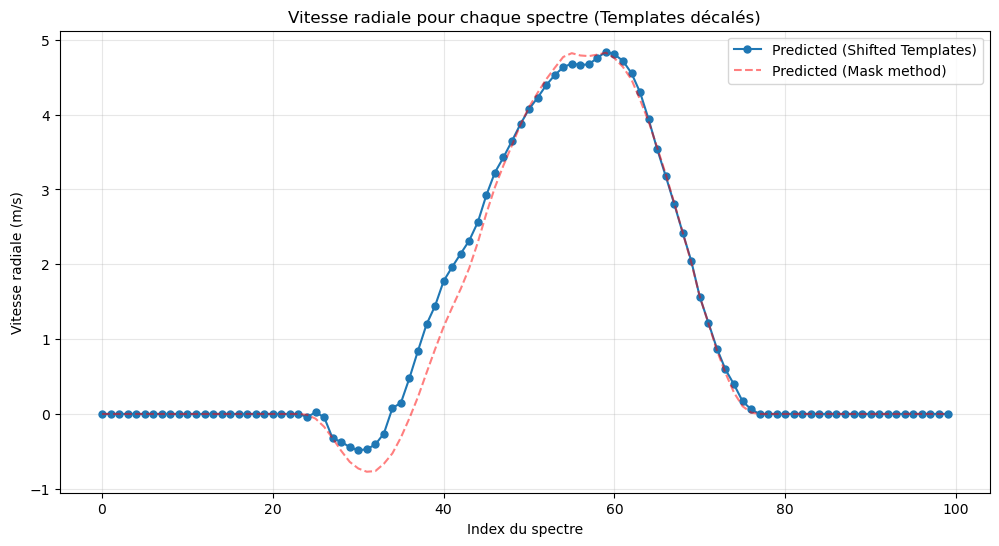

In [10]:
# Plot des RV prédit et vrai
plt.figure(figsize=(12, 6))
plt.plot(np.arange(len(rvs_shifted_templates)), rvs_shifted_templates, 'o-', label='Predicted (Shifted Templates)', markersize=5)
plt.plot(np.arange(len(rvs_shifted_templates)), rvs, 'r--', label='Predicted (Mask method)', alpha=0.5)
plt.xlabel('Index du spectre')
plt.ylabel('Vitesse radiale (m/s)')
plt.title('Vitesse radiale pour chaque spectre (Templates décalés)')
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()


In [38]:
def torch_interp(x: torch.Tensor, xp: torch.Tensor, fp: torch.Tensor, dim: int=-1, extrapolate: str='constant') -> torch.Tensor:
    """One-dimensional linear interpolation between monotonically increasing sample
    points, with extrapolation beyond sample points.

    Returns the one-dimensional piecewise linear interpolant to a function with
    given discrete data points :math:`(xp, fp)`, evaluated at :math:`x`.

    Args:
        x: The :math:`x`-from torchcubicspline import natural_cubic_spline_coeffs values, same size as `x`.
    """
    # Move the interpolation dimension to the last axis
    x = x.movedim(dim, -1).contiguous()
    xp = xp.movedim(dim, -1).contiguous()
    fp = fp.movedim(dim, -1).contiguous()

    m = torch.diff(fp) / torch.diff(xp) # slope
    b = fp[..., :-1] - m * xp[..., :-1] # offset
    indices = torch.searchsorted(xp, x, right=False)

    if extrapolate == 'constant':
        # Pad m and b to get constant values outside of xp range
        m = torch.cat([torch.zeros_like(m)[..., :1], m, torch.zeros_like(m)[..., :1]], dim=-1)
        b = torch.cat([fp[..., :1], b, fp[..., -1:]], dim=-1)
    else: # extrapolate == 'linear'
        indices = torch.clamp(indices - 1, 0, m.shape[-1] - 1)

    values = m.gather(-1, indices) * x + b.gather(-1, indices)

    return values.movedim(-1, dim)

# Shift un batch de spectre avec un batch de vitesses d'offset données
def doppler_shift_batch(wave_torch64, batch_yobs, batch_voffset):
    """
        Simule un shift doppler pour un batch de spectre de dim [B, n_pixel] et un batch de vitesse d'offset de taille [B, 1]
        Retourne un batch de spectres augmentés de taille [B, n_pixel]

        On dispose de différentes d'interpolation :

            * torch_interp -> Méthode linéaire parrallélisée -> gain de perf
            * cubic_transform -> Le plus lent, Méthode utilisée par AESTRA

    """

    c_tensor = torch.tensor(299792458.0, dtype=torch.float64, device=batch_yobs.device)  # Vitesse de la lumière en m/s

    # On travaille par batch
    B = batch_yobs.shape[0]

    batch_wave = wave_torch64.unsqueeze(0) # [n_pixel] -> [1, n_pixel]
    batch_wave = batch_wave.expand(B, -1) # [B, n_pixel]


    if batch_voffset.dtype != 'torch.float64':
        batch_voffset = batch_voffset.double()

    if batch_yobs.dtype != 'torch.float64':
        batch_yobs = batch_yobs.double()

    batch_doppler_factor = torch.sqrt( (1 + batch_voffset/c_tensor) /  (1 - batch_voffset/c_tensor)) # [B, 1]
    # Pour vérifier si le facteur gamma ne vaut pas bêtement 1 pour cause de précision
    # print('Valeur du facteur gamma : ', batch_doppler_factor[0].item())

    batch_wave_shifted = batch_wave * batch_doppler_factor # [B, n_pixel] * [B, 1] (Ressort en float64)

    batch_yaug = torch_interp(batch_wave, batch_wave_shifted, batch_yobs) # [B, n_pixel] en float64

    return batch_yaug.float()


Kp = 10
P = 10
n_spectra = 100
t = torch.arange(0, n_spectra, dtype=torch.float64)  # Temps en secondes
batch_voffset = Kp * torch.sin(t * 2*torch.pi / P)

# dataset = doppler_shift_batch(
#     wave_torch64=torch.tensor(wavegrid, dtype=torch.float64),  # [n_pixel] (grille de longueur d'onde)
#     batch_yobs=torch.tensor(spec_quiet, dtype=torch.float64).unsqueeze(0).expand(n_spectra, -1),  # [n_spectra, n_pixel] (batch de spectres)
#     batch_voffset=batch_voffset.unsqueeze(1)  # [n_spectra, 1] -> [n_spectra, 1] (batch de vitesses d'
# )

dataset = doppler_shift_batch(
    wave_torch64=torch.tensor(wavegrid, dtype=torch.float64),  # [n_pixel] (grille de longueur d'onde)
    batch_yobs=torch.tensor(specs),  # [n_spectra, n_pixel] (batch de spectres)
    batch_voffset=batch_voffset.unsqueeze(1)  # [n_spectra, 1] -> [n_spectra, 1] (batch de vitesses d'
)

In [39]:
v_grid = np.linspace(-20000, 20000, 100)  # Grille de vitesses radiales

window_size_velocity = 820  # en m/s (paramètre)
masks = calculate_all_masks(line_pos, line_weights, v_grid, wavegrid, window_size_velocity)
rvs_mask_method = []
for i in range(n_spectra):
    ccf = calculate_CCF(masks, spec=dataset[i].numpy())
    results = fitter.fit_ccf(v_grid, ccf, continuum='linear', verbose=False)
    rv = results['rv_center']
    rvs_mask_method.append(rv)
    # Affichage des résultats du fit pour chaque spectre
    print(f"Spectre {i+1}: RV Centre = {results['rv_center']:.3f} m/s, Amplitude = {results['amplitude']:.3f}, FWHM = {results['fwhm']:.3f} m/s")

rvs_mask_method = np.array(rvs_mask_method)

rvs_shifted_templates = []

shifted_templates = calculate_all_shifted_templates_batched(
    template=spec_quiet,
    v_grid=v_grid,
    wavegrid=wavegrid,
    batch_size=10
)

for i in range(n_spectra):
    ccf = calculate_CCF(shifted_templates, spec=dataset[i].numpy())
    results = fitter.fit_ccf(v_grid, ccf, continuum='linear', verbose=False)
    rv = results['rv_center']
    rvs_shifted_templates.append(rv)
    # Affichage des résultats du fit pour chaque spectre
    print(f"Spectre {i+1}: RV Centre = {results['rv_center']:.3f} m/s, Amplitude = {results['amplitude']:.3f}, FWHM = {results['fwhm']:.3f} m/s")
rvs_shifted_templates = np.array(rvs_shifted_templates)

rvs_shifted_templates -= rvs_shifted_templates[0]  # Centrage autour de la première vitesse radiale
rvs_mask_method -= rvs_mask_method[0]  # Centrage autour de la première vitesse radiale

Spectre 1: RV Centre = -137.983 m/s, Amplitude = -0.488, FWHM = 6282.007 m/s
Spectre 2: RV Centre = -132.140 m/s, Amplitude = -0.487, FWHM = 6282.789 m/s
Spectre 3: RV Centre = -128.527 m/s, Amplitude = -0.487, FWHM = 6283.259 m/s
Spectre 4: RV Centre = -128.527 m/s, Amplitude = -0.487, FWHM = 6283.259 m/s
Spectre 5: RV Centre = -132.140 m/s, Amplitude = -0.487, FWHM = 6282.789 m/s
Spectre 6: RV Centre = -137.983 m/s, Amplitude = -0.488, FWHM = 6282.007 m/s
Spectre 7: RV Centre = -143.844 m/s, Amplitude = -0.487, FWHM = 6282.679 m/s
Spectre 8: RV Centre = -147.467 m/s, Amplitude = -0.487, FWHM = 6283.080 m/s
Spectre 9: RV Centre = -147.467 m/s, Amplitude = -0.487, FWHM = 6283.080 m/s
Spectre 10: RV Centre = -143.844 m/s, Amplitude = -0.487, FWHM = 6282.679 m/s
Spectre 11: RV Centre = -137.983 m/s, Amplitude = -0.488, FWHM = 6282.007 m/s
Spectre 12: RV Centre = -132.140 m/s, Amplitude = -0.487, FWHM = 6282.789 m/s
Spectre 13: RV Centre = -128.527 m/s, Amplitude = -0.487, FWHM = 6283.259

In [40]:
plt.figure(figsize=(12, 6)) 
plt.plot(t.numpy(), rvs_mask_method, 'o-', label='RV (Mask Method)', markersize=5)
plt.plot(t.numpy(), rvs_shifted_templates, 'g-', label='RV (Shifted Templates)', markersize=5)
plt.plot(t.numpy(), batch_voffset.numpy(), 'r--', label='True RV (Kp*sin(t/P))', alpha=0.5)
plt.xlabel('Index du spectre')
plt.ylabel('Vitesse radiale (m/s)')
plt.title('Vitesse radiale pour chaque spectre (Mask Method)')
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()

# Erreurs de prédiction
errors_mask_method = rvs_mask_method - batch_voffset.numpy()
errors_shifted_templates = rvs_shifted_templates - batch_voffset.numpy()
plt.figure(figsize=(12, 6))
plt.plot(t.numpy(), errors_mask_method, 'o-', label='Erreur de prédiction (Mask Method)', markersize=5)
plt.plot(t.numpy(), errors_shifted_templates, 'g-', label='Erreur de prédiction (Shifted Templates)', markersize=5)
plt.axhline(0, color='k', linestyle='--', alpha=0.5)
plt.xlabel('Index du spectre')
plt.ylabel('Erreur de prédiction (m/s)')
plt.title('Erreur de prédiction pour chaque spectre (Mask Method)')
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()

In [41]:
# Périodogrammes

from astropy.timeseries import LombScargle

frequency, power_mask_method = LombScargle(t.numpy(), rvs_mask_method).autopower()
frequency, power_shifted_templates = LombScargle(t.numpy(), rvs_shifted_templates).autopower()

period = 1 / frequency  # Période en secondes

%matplotlib qt
plt.figure(figsize=(12, 6))
plt.plot(period, power_mask_method, label='Périodogramme (Mask Method)', alpha=0.7)
plt.plot(period, power_shifted_templates, label='Périodogramme (Shifted Templates)', alpha=0.7)
plt.xlabel('Période (s)')
plt.ylabel('Puissance')
plt.title('Périodogrammes des vitesses radiales')
plt.legend()
plt.grid(True, which='both', alpha=0.3)
plt.show()